In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

### Device configuration

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load the MNIST Dataset

In [3]:
# Define a transform to normalize the data (Preprocessing)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)) ])

# Download and load the training data
trainset    = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset    = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
dataiter=iter(trainloader)
images, labels=dataiter.next()

In [5]:
print(trainloader)
print(testloader)

In [6]:
print(trainset.data.size())
print(testset.data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


### Visualization of MNIST

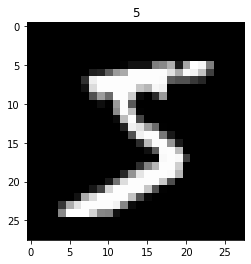

In [7]:
plt.imshow(trainset.data[0], cmap='gray')
plt.title('%i' % trainset.targets[0])
plt.show()

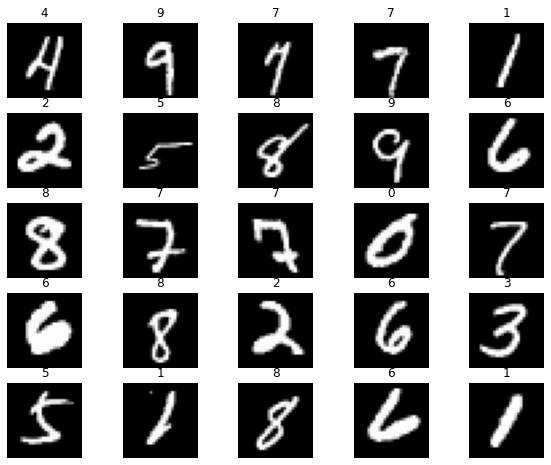

In [8]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [9]:
def view_classify(img, ps):

    ps = ps.cpu().data.numpy().squeeze()
    img= img.cpu().data.numpy()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.reshape(1, 28, 28).squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

### CNN model

In [10]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()

#         self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels= 16, kernel_size= 5, stride= 1, padding= 2),
#                                     nn.ReLU(),
#                                     nn.MaxPool2d(2))
#         self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 5, 1, 2),
#                                     nn.ReLU(),
#                                     nn.MaxPool2d(2))
#         self.out = nn.Linear(32 * 7 * 7, 10)            # output 10 classes

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = x.view(x.shape[0], -1)
#         output = self.out(x)
#         return output

# cnn = CNN()
# cnn.to(device)
# print(cnn)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1=nn.Conv2d(1, 32, 5, padding=1, stride=2)
        self.pool=nn.MaxPool2d(2,2)

        self.conv2=nn.Conv2d(32, 16, 5)
        self.fc1=nn.Linear(16*1*1, 128)
        self.fc2=nn.Linear(128, 64)
        self.fc3=nn.Linear(64,10)

    def forward(self, x):
        #print(x.shape)
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x=x.view(x.shape[0], -1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        #x=F.softmax(x, dim=1)
        return x


cnn = CNN()
cnn.to(device)
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


### Loss and Optimization Function

In [12]:
loss_func = nn.CrossEntropyLoss()
print(loss_func)

optimizer = optim.Adam(cnn.parameters(), lr= 0.001)
print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0
)


### Train the model

In [13]:
epochs = 10
print_every = 40

def fit(model, trainloader, testloader, loss_func, optimizer, num_epochs):
    for epoch in range(num_epochs):

        #save checkpoint models in every 10th epoch
        if (epoch+1) % 10 == 0:
            torch.save(cnn.state_dict(), f'checkpoint_{epoch+1}.pth')

        current_loss = 0
        print(f"Epoch: {epoch+1}/{num_epochs}")

        for i, (images, labels) in enumerate(iter(trainloader)):
            images, labels = images.to(device), labels.to(device)   #for cuda 
            # images.resize_(images.size()[0], 784)
            
            optimizer.zero_grad()
            
            output = model.forward(images)   # 1) Forward pass
            loss = loss_func(output, labels) # 2) Compute loss
            loss.backward()                  # 3) Backward pass
            optimizer.step()                 # 4) Update model
            
            current_loss += loss.item()
            
            # if i % print_every == 0:
            #     loss_value = current_loss/print_every
            #     print(f"\tIteration: {i}\t Loss: {current_loss/print_every:.4f}")
            #     current_loss = 0

        model.eval()
        acc_list = []
        with torch.no_grad():
            for i, (images_test, labels_test) in enumerate(iter(testloader)):
                    images_test, labels_test = images_test.to(device), labels_test.to(device)
                    # images.resize_(images.size()[0], 784)
                    probability = F.softmax(model(images_test), dim=1)
                    pred = probability.argmax(dim=1)
                    acc = (pred == labels_test).sum() / len(labels_test)
                    acc_list.append(acc.item())     # need to add .item()
        print(f'Mean accuracy is {np.array(acc_list).mean()} after epoch {epoch+1}')

        model.train()





In [69]:
results = fit(cnn, trainloader, testloader, loss_func, optimizer, epochs)

Epoch: 1/10
Mean accuracy is 0.9895501592356688 after epoch 1
Epoch: 2/10
Mean accuracy is 0.9903463375796179 after epoch 2
Epoch: 3/10
Mean accuracy is 0.9909434713375797 after epoch 3
Epoch: 4/10
Mean accuracy is 0.9884554140127388 after epoch 4
Epoch: 5/10
Mean accuracy is 0.990047770700637 after epoch 5
Epoch: 6/10
Mean accuracy is 0.9894506369426752 after epoch 6
Epoch: 7/10
Mean accuracy is 0.988953025477707 after epoch 7
Epoch: 8/10
Mean accuracy is 0.990843949044586 after epoch 8
Epoch: 9/10
Mean accuracy is 0.9914410828025477 after epoch 9
Epoch: 10/10
Mean accuracy is 0.9899482484076433 after epoch 10


### Load the model

In [19]:
load_model = torch.load('checkpoint_10.pth')
cnn.load_state_dict(load_model)

<All keys matched successfully>

### Prediction

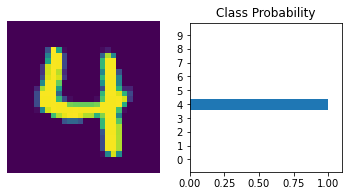

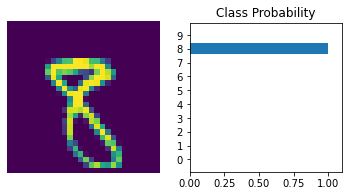

In [23]:
counter = 0
while counter < 2:
    index = np.random.randint(0,10)
    images, labels = next(iter(testloader))
    images=images.to(device)
    labels=labels.to(device)
    image=images[index]    
    logits = cnn.forward(image.view(1,1,28,28))
    ps = F.softmax(logits, dim=1)
    view_classify(image.view(1, 28, 28), ps)
    plt.show()
    counter += 1